# Land use classification of Indian Sundarban region using Sentinel-2 imagery in Google Earth Engine and CRIB platform


### Submitted by Group:1

1. Hasan Md. Hamidur Rahman
1. Afroza Begum
1. Debolina Sarkar


## Background

Sundarban the world’s largest mangrove forest delta covering India to Bangladesh, provides a wide range of ecosystem services and contributes to socio-economic development of the neighbouring communities. Agriculture is the main source of sustenance following rice based farming system for major part of this population. But there are huge area of potential farming land which are fallow in this region. The information of fallow area is lack to the policy planner which is important to make comprehensive plan to secure the livelihood of the population. In this project, land use classification will be done through which total fallow area of ‘Gosaba’ block located in Indian part will be estimated and delineated in map.
## Objectives:

<i>With this project, we can compare the results of different supervised machine learning algorithm for the classification of land use of our study area.

1. Study different supervised clssification algorithm In GEE and CRIB
1. Accuracy assesement 
1. Select the best classification algorithm for fallow mapping purpose </i>




## Methodology

<img src="Methods.png">

### 1. Downloading and Preprocessing of satellite data
var fc_shape=ee.FeatureCollection(table);
var fc_point=ee.FeatureCollection(table2);

Map.centerObject(fc_shape,11);
Map.addLayer(fc_shape,{},'Sundarban',false);

Map.addLayer(fc_point,{},'Point',false);

var image1= ee.ImageCollection("COPERNICUS/S2_SR")
  .filterDate('2020-12-01','2021-03-31')
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10))
  .filterBounds(fc_shape)
  .median();
  
Export.image.toDrive({
  image:image1,
  description:'land_type ' ,
  scale:30,
  region:fc_shape 
})



### Import modules

In [1]:
from dask.distributed import Client
client = Client()

import numpy as np
from osgeo import gdal
# import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import georasters as gr
import geopandas as gpd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import georasters as gr

#geoespatial operations with dask and geopandas

from dask.base import compute
import esda 
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns  #Helps us in data visualization
plt.rcParams["figure.figsize"] = (10, 5) 

/usr/local/lib/python3.8/dist-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43363 instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### 2. Exploratory Spatial Data Analysis (ESDA) (for training_data)

In [2]:
# Read the shapefile data (training_point_WGS.shp)

training_data= 'training_point_WGS.shp'


training_data = gpd.read_file(training_data)
training_data.head()

,id,land type,B2 (MEAN),B3 (MEAN),B4 (MEAN),B5 (MEAN),B6 (MEAN),B7 (MEAN),B8 (MEAN),B8A (MEAN),B11 (MEAN),B12 (MEAN),geometry
0,1,water,574.666667,541.888889,503.222222,502.111111,575.111111,584.222222,579.000000,577.777778,354.000000,260.111111,POINT (88.82977 22.19283)
1,1,water,550.222222,527.444444,489.444444,510.111111,630.111111,622.666667,631.666667,620.777778,414.555556,296.000000,POINT (88.85130 22.20264)
2,1,water,540.222222,523.444444,462.555556,464.777778,562.666667,574.000000,558.555556,564.222222,350.222222,262.333333,POINT (88.83243 22.18752)
3,1,water,529.666667,517.222222,480.666667,516.444444,633.000000,662.555556,647.888889,660.000000,433.000000,305.222222,POINT (88.84313 22.19021)
4,1,water,534.111111,550.333333,639.333333,732.000000,629.444444,688.000000,642.666667,592.444444,357.222222,264.444444,POINT (88.77147 22.19185)


#####  This table shows first five rows of 13 columns (ten different bands alongwith id,land type and geometry) of ground truth data frame. All of the band columns show the numeric value. And the ID, land_type and geometry column shows the categorical, string and point value, respectively.

In [3]:
training_data.info()  #gives information about all the variables of training set.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          200 non-null    int64   
 1   land type   200 non-null    object  
 2   B2 (MEAN)   200 non-null    float64 
 3   B3 (MEAN)   200 non-null    float64 
 4   B4 (MEAN)   200 non-null    float64 
 5   B5 (MEAN)   200 non-null    float64 
 6   B6 (MEAN)   200 non-null    float64 
 7   B7 (MEAN)   200 non-null    float64 
 8   B8 (MEAN)   200 non-null    float64 
 9   B8A (MEAN)  200 non-null    float64 
 10  B11 (MEAN)  200 non-null    float64 
 11  B12 (MEAN)  200 non-null    float64 
 12  geometry    200 non-null    geometry
dtypes: float64(10), geometry(1), int64(1), object(1)
memory usage: 20.4+ KB


##### Info tables of training data indicates that there are a total of 200 entries and 13 columns in the dataset. 

<AxesSubplot:>

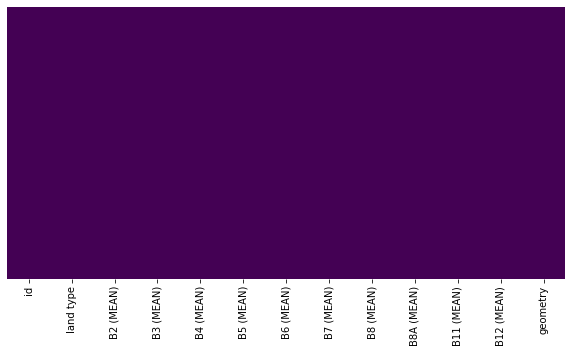

In [4]:
#checking for columns having any missing values.
sns.heatmap(training_data.isnull(), yticklabels=False, cbar=False, cmap="viridis")

##### Heatmap shows there are no missing value in the columns. 

In [5]:
training_data.isnull().sum()

id            0
land type     0
B2 (MEAN)     0
B3 (MEAN)     0
B4 (MEAN)     0
B5 (MEAN)     0
B6 (MEAN)     0
B7 (MEAN)     0
B8 (MEAN)     0
B8A (MEAN)    0
B11 (MEAN)    0
B12 (MEAN)    0
geometry      0
dtype: int64

##### There are no null value present in the columns.

In [7]:
training_data.describe()

,id,B2 (MEAN),B3 (MEAN),B4 (MEAN),B5 (MEAN),B6 (MEAN),B7 (MEAN),B8 (MEAN),B8A (MEAN),B11 (MEAN),B12 (MEAN)
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3.300000,480.635000,503.305000,661.960278,922.432222,1439.900000,1624.805000,1710.036667,1801.731111,1871.704167,1387.781944
std,1.695397,106.293599,127.569349,257.979397,269.666409,392.678854,469.344055,539.381823,565.168943,915.980272,754.565780
min,1.000000,276.111111,255.111111,242.333333,330.666667,403.888889,411.777778,411.777778,410.888889,243.111111,184.222222
25%,2.000000,400.083333,406.666667,456.250000,727.333333,1255.000000,1395.305556,1420.500000,1484.861111,1215.638889,803.305556
50%,3.000000,465.944444,488.222222,569.444444,840.944444,1435.055556,1616.555556,1744.666667,1868.222222,1699.055556,1197.500000
75%,5.000000,565.611111,580.611111,911.833333,1122.250000,1770.750000,2011.388889,2175.277778,2286.555556,2764.527778,2210.166667
max,6.000000,767.333333,876.555556,1190.222222,1463.333333,2335.777778,2660.111111,2836.555556,2948.222222,3649.111111,2703.000000


##### From the description table, it is observed that 

 * the statistical summary about the data such as mean, max, min, standard deviation, count, along with this we can also pass the percentiles.
 * all the colums represent the similar number of records 
 * The band mean values are ranges from 3.300000 to 1871.704167

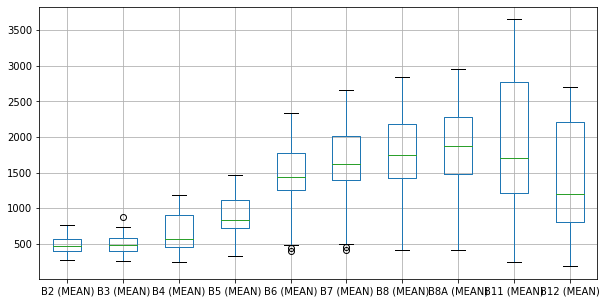

In [8]:
training_data.boxplot(column=['B2 (MEAN)', 'B3 (MEAN)', 'B4 (MEAN)', 'B5 (MEAN)', 'B6 (MEAN)','B7 (MEAN)','B8 (MEAN)','B8A (MEAN)','B11 (MEAN)','B12 (MEAN)'])
plt.show()

In [67]:
df_shp = gpd.read_file('training_point_WGS.shp')
df_dask = df_shp
df_dask

,id,land type,B2 (MEAN),B3 (MEAN),B4 (MEAN),B5 (MEAN),B6 (MEAN),B7 (MEAN),B8 (MEAN),B8A (MEAN),B11 (MEAN),B12 (MEAN),geometry
0,1,water,574.666667,541.888889,503.222222,502.111111,575.111111,584.222222,579.000000,577.777778,354.000000,260.111111,POINT (88.82977 22.19283)
1,1,water,550.222222,527.444444,489.444444,510.111111,630.111111,622.666667,631.666667,620.777778,414.555556,296.000000,POINT (88.85130 22.20264)
2,1,water,540.222222,523.444444,462.555556,464.777778,562.666667,574.000000,558.555556,564.222222,350.222222,262.333333,POINT (88.83243 22.18752)
3,1,water,529.666667,517.222222,480.666667,516.444444,633.000000,662.555556,647.888889,660.000000,433.000000,305.222222,POINT (88.84313 22.19021)
4,1,water,534.111111,550.333333,639.333333,732.000000,629.444444,688.000000,642.666667,592.444444,357.222222,264.444444,POINT (88.77147 22.19185)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,6,submergence,460.888889,452.333333,496.222222,773.444444,1189.000000,1312.222222,1297.000000,1324.333333,729.888889,470.777778,POINT (88.88296 22.18957)
196,6,submergence,477.000000,472.777778,539.888889,821.444444,1152.777778,1258.555556,1253.888889,1256.777778,785.111111,551.111111,POINT (88.93045 22.20274)
197,6,submergence,451.777778,451.444444,461.111111,737.555556,1283.111111,1427.555556,1440.333333,1437.666667,849.111111,553.000000,POINT (88.88599 22.19937)
198,6,submergence,406.888889,427.666667,435.333333,748.666667,1260.444444,1370.444444,1347.666667,1385.666667,816.333333,529.222222,POINT (88.90940 22.18131)


In [ ]:
df_dask.describe ()

,id,B2 (MEAN),B3 (MEAN),B4 (MEAN),B5 (MEAN),B6 (MEAN),B7 (MEAN),B8 (MEAN),B8A (MEAN),B11 (MEAN),B12 (MEAN)
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3.300000,480.635000,503.305000,661.960278,922.432222,1439.900000,1624.805000,1710.036667,1801.731111,1871.704167,1387.781944
std,1.695397,106.293599,127.569349,257.979397,269.666409,392.678854,469.344055,539.381823,565.168943,915.980272,754.565780
min,1.000000,276.111111,255.111111,242.333333,330.666667,403.888889,411.777778,411.777778,410.888889,243.111111,184.222222
25%,2.000000,400.083333,406.666667,456.250000,727.333333,1255.000000,1395.305556,1420.500000,1484.861111,1215.638889,803.305556
50%,3.000000,465.944444,488.222222,569.444444,840.944444,1435.055556,1616.555556,1744.666667,1868.222222,1699.055556,1197.500000
75%,5.000000,565.611111,580.611111,911.833333,1122.250000,1770.750000,2011.388889,2175.277778,2286.555556,2764.527778,2210.166667
max,6.000000,767.333333,876.555556,1190.222222,1463.333333,2335.777778,2660.111111,2836.555556,2948.222222,3649.111111,2703.000000


#### The above result shows the data analysis using distributed computing (DASK)

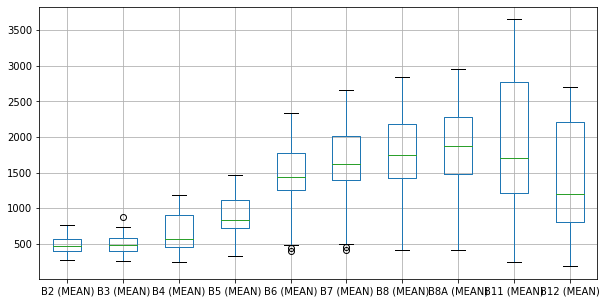

In [69]:
df_dask.boxplot(column=['B2 (MEAN)', 'B3 (MEAN)', 'B4 (MEAN)', 'B5 (MEAN)', 'B6 (MEAN)','B7 (MEAN)','B8 (MEAN)','B8A (MEAN)','B11 (MEAN)','B12 (MEAN)'])
plt.show()

#### The above plot shows the result by using distributed computing (DASK)

### 3. Exploratory Spatial Data Analysis (ESDA) (for bands)

##### Image data reading by georaster

In [9]:
B2 = gr.from_file('Band_02.tif')
B3 = gr.from_file('Band_03.tif')
B4 = gr.from_file('Band_04.tif')
B5 = gr.from_file('Band_05.tif')
B6 = gr.from_file('Band_06.tif')
B7 = gr.from_file('Band_07.tif')
B8 = gr.from_file('Band_08.tif')
B8A = gr.from_file('Band_08A.tif')
B11 = gr.from_file('Band_11.tif')
B12 = gr.from_file('Band_12.tif')

(<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>)

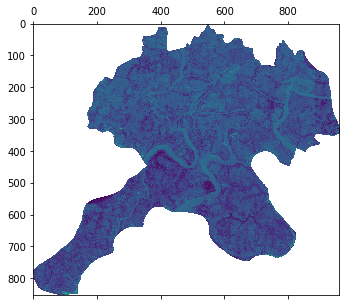

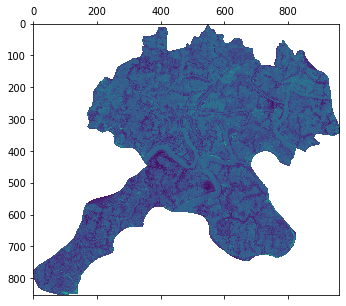

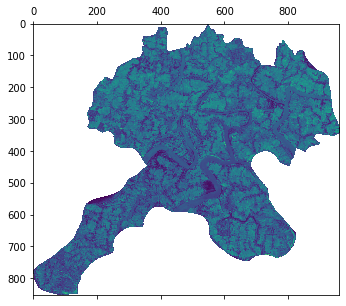

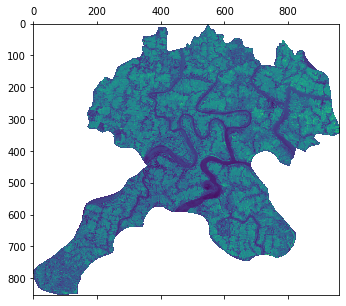

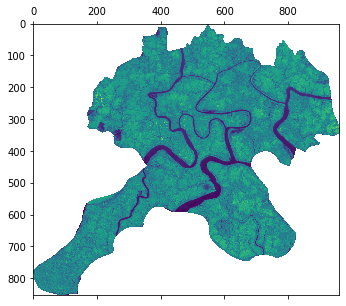

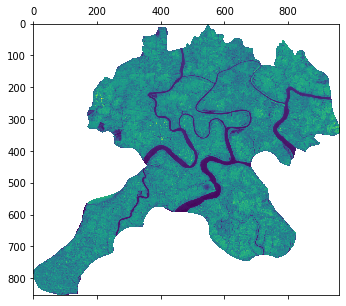

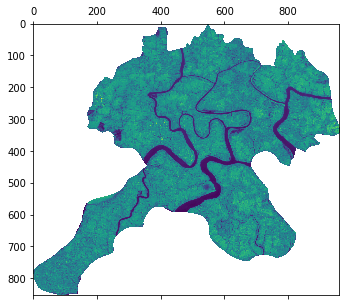

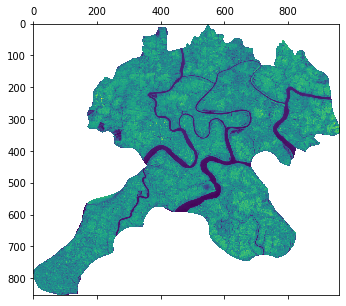

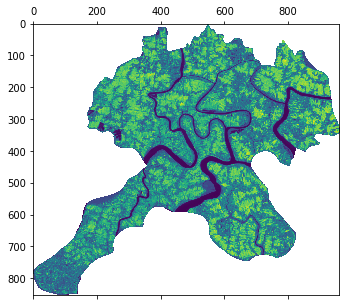

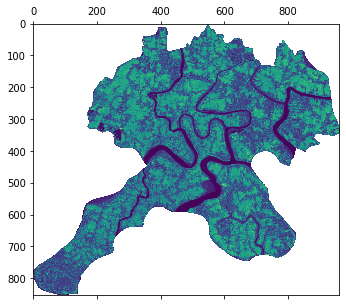

In [10]:
# Visualization of bands

B2.plot(), B3.plot(), B4.plot(), B5.plot(), B6.plot(),
B7.plot(), B8.plot(), B8A.plot(), B11.plot(), B12.plot()

In [11]:
# Define some functions that can read an image with the help of pandas

df_B2 = B2.to_pandas()
df_B3 = B3.to_pandas()
df_B4 = B4.to_pandas()
df_B5 = B5.to_pandas()
df_B6 = B6.to_pandas()
df_B7 = B7.to_pandas()
df_B8 = B8.to_pandas()
df_B8A = B8A.to_pandas()
df_B11 = B11.to_pandas()
df_B12 = B12.to_pandas()

In [12]:
# Column Reduction and Rename Column Headers

df_B2 = df_B2.loc[:, ['value', 'x', 'y']]
df_B2 = df_B2.rename(columns = {'value':'B2', 'x':'Longitude', 'y':'Latitude'})

df_B3 = df_B3.loc[:, ['value', 'x', 'y']]
df_B3 = df_B3.rename(columns = {'value':'B3', 'x':'Longitude', 'y':'Latitude'})

df_B4 = df_B4.loc[:, ['value', 'x', 'y']]
df_B4 = df_B4.rename(columns = {'value':'B4', 'x':'Longitude', 'y':'Latitude'})

df_B5 = df_B5.loc[:, ['value', 'x', 'y']]
df_B5 = df_B5.rename(columns = {'value':'B5', 'x':'Longitude', 'y':'Latitude'})

df_B6 = df_B6.loc[:, ['value', 'x', 'y']]
df_B6 = df_B6.rename(columns = {'value':'B6', 'x':'Longitude', 'y':'Latitude'})

df_B7 = df_B7.loc[:, ['value', 'x', 'y']]
df_B7 = df_B7.rename(columns = {'value':'B7', 'x':'Longitude', 'y':'Latitude'})

df_B8 = df_B8.loc[:, ['value', 'x', 'y']]
df_B8 = df_B8.rename(columns = {'value':'B8', 'x':'Longitude', 'y':'Latitude'})

df_B8A = df_B8A.loc[:, ['value', 'x', 'y']]
df_B8A = df_B8A.rename(columns = {'value':'B8A', 'x':'Longitude', 'y':'Latitude'})

df_B11 = df_B11.loc[:, ['value', 'x', 'y']]
df_B11 = df_B11.rename(columns = {'value':'B11', 'x':'Longitude', 'y':'Latitude'})

df_B12 = df_B12.loc[:, ['value', 'x', 'y']]
df_B12 = df_B12.rename(columns = {'value':'B12', 'x':'Longitude', 'y':'Latitude'})

In [13]:
df_B2.head(), df_B3.head(), df_B4.head(), df_B5.head(), df_B6.head(), 
df_B7.head(), df_B8.head(), df_B8A.head(), df_B11.head(), df_B12.head()

(       B7  Longitude   Latitude
 0  1808.0  88.849670  22.287202
 1  1556.0  88.849939  22.287202
 2  2014.0  88.849400  22.286933
 3  1797.0  88.849670  22.286933
 4  1573.0  88.849939  22.286933,
        B8  Longitude   Latitude
 0  1792.0  88.849670  22.287202
 1  1555.0  88.849939  22.287202
 2  2191.0  88.849400  22.286933
 3  1768.0  88.849670  22.286933
 4  1602.0  88.849939  22.286933,
       B8A  Longitude   Latitude
 0  1866.0  88.849670  22.287202
 1  1592.0  88.849939  22.287202
 2  2117.0  88.849400  22.286933
 3  1875.0  88.849670  22.286933
 4  1550.0  88.849939  22.286933,
       B11  Longitude   Latitude
 0  1810.0  88.849670  22.287202
 1  1438.0  88.849939  22.287202
 2  2191.0  88.849400  22.286933
 3  1850.0  88.849670  22.286933
 4  1472.0  88.849939  22.286933,
       B12  Longitude   Latitude
 0  1444.0  88.849670  22.287202
 1  1056.0  88.849939  22.287202
 2  1867.0  88.849400  22.286933
 3  1451.0  88.849670  22.286933
 4  1137.0  88.849939  22.286933)

In [14]:
df_B2.shape, df_B3.shape, df_B4.shape, df_B5.shape, df_B6.shape, 
df_B7.shape, df_B8.shape, df_B8A.shape, df_B11.shape, df_B12.shape

((388372, 3), (388372, 3), (388372, 3), (388372, 3), (388372, 3))

In [16]:
# Cocatenation of all the band values
import pandas as pd
df = pd.concat([df_B2['B2'],df_B3['B3'], df_B4['B4'],df_B5['B5'],df_B6['B6'],df_B7['B7'],df_B8['B8'],
                df_B8A['B8A'],df_B11['B11'],df_B12], axis=1)
df

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Longitude,Latitude
0,1128.0,1258.0,1230.0,1408.0,1667.0,1808.0,1792.0,1866.0,1810.0,1444.0,88.849670,22.287202
1,1101.0,1204.0,1133.0,1298.0,1502.0,1556.0,1555.0,1592.0,1438.0,1056.0,88.849939,22.287202
2,1149.0,1313.0,1370.0,1567.0,1897.0,2014.0,2191.0,2117.0,2191.0,1867.0,88.849400,22.286933
3,1115.0,1230.0,1213.0,1411.0,1636.0,1797.0,1768.0,1875.0,1850.0,1451.0,88.849670,22.286933
4,1097.0,1190.0,1139.0,1292.0,1512.0,1573.0,1602.0,1550.0,1472.0,1137.0,88.849939,22.286933
...,...,...,...,...,...,...,...,...,...,...,...,...
388367,1191.0,1340.0,1188.0,1157.0,887.0,878.0,774.0,728.0,328.0,226.0,88.731092,22.057593
388368,1197.0,1357.0,1217.0,1133.0,884.0,877.0,813.0,741.0,303.0,188.0,88.731362,22.057593
388369,1201.0,1353.0,1175.0,1114.0,876.0,872.0,760.0,722.0,315.0,203.0,88.731631,22.057593
388370,1188.0,1308.0,1195.0,1092.0,841.0,837.0,773.0,695.0,297.0,187.0,88.731901,22.057593


#####  There are 388372 rows and 12 columns (ten different bands alongwith Longitude and Latitude) in this image data frame. All of the column shows the numeric value.

In [17]:
df.info()  #gives information about all the variables of image dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388372 entries, 0 to 388371
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   B2         388372 non-null  float64
 1   B3         388372 non-null  float64
 2   B4         388372 non-null  float64
 3   B5         388372 non-null  float64
 4   B6         388372 non-null  float64
 5   B7         388372 non-null  float64
 6   B8         388372 non-null  float64
 7   B8A        388372 non-null  float64
 8   B11        388372 non-null  float64
 9   B12        388372 non-null  float64
 10  Longitude  388372 non-null  float64
 11  Latitude   388372 non-null  float64
dtypes: float64(12)
memory usage: 35.6 MB


##### Info tables of image data indicates that there are a total of 388372 entries and 12 columns in the dataset.

In [18]:
# Conversion to Geopandas

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Longitude,Latitude,geometry
0,1128.0,1258.0,1230.0,1408.0,1667.0,1808.0,1792.0,1866.0,1810.0,1444.0,88.849670,22.287202,POINT (88.84967 22.28720)
1,1101.0,1204.0,1133.0,1298.0,1502.0,1556.0,1555.0,1592.0,1438.0,1056.0,88.849939,22.287202,POINT (88.84994 22.28720)
2,1149.0,1313.0,1370.0,1567.0,1897.0,2014.0,2191.0,2117.0,2191.0,1867.0,88.849400,22.286933,POINT (88.84940 22.28693)
3,1115.0,1230.0,1213.0,1411.0,1636.0,1797.0,1768.0,1875.0,1850.0,1451.0,88.849670,22.286933,POINT (88.84967 22.28693)
4,1097.0,1190.0,1139.0,1292.0,1512.0,1573.0,1602.0,1550.0,1472.0,1137.0,88.849939,22.286933,POINT (88.84994 22.28693)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388367,1191.0,1340.0,1188.0,1157.0,887.0,878.0,774.0,728.0,328.0,226.0,88.731092,22.057593,POINT (88.73109 22.05759)
388368,1197.0,1357.0,1217.0,1133.0,884.0,877.0,813.0,741.0,303.0,188.0,88.731362,22.057593,POINT (88.73136 22.05759)
388369,1201.0,1353.0,1175.0,1114.0,876.0,872.0,760.0,722.0,315.0,203.0,88.731631,22.057593,POINT (88.73163 22.05759)
388370,1188.0,1308.0,1195.0,1092.0,841.0,837.0,773.0,695.0,297.0,187.0,88.731901,22.057593,POINT (88.73190 22.05759)


##### This table shows entries of first five rows and last five rows of 13 columns (B2, 	B3, 	B4, 	B5, 	B6, 	B7, 	B8, 	B8A, 	B11, 	B12, 	Longitude, 	Latitude and 	geometry). 

<AxesSubplot:>

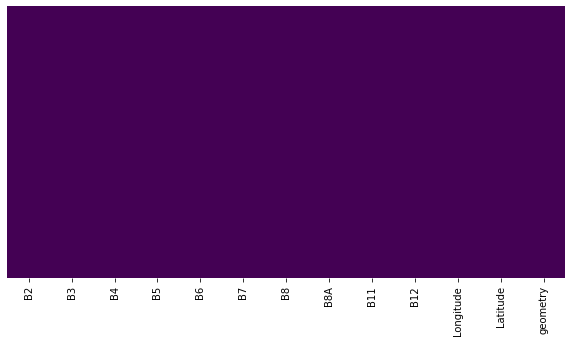

In [19]:
#checking for columns having any missing values.
sns.heatmap(gdf.isnull(), yticklabels=False, cbar=False, cmap="viridis")

##### Heatmap shows there are no missing value in the columns. 

In [20]:
gdf.isnull().sum()

B2           0
B3           0
B4           0
B5           0
B6           0
B7           0
B8           0
B8A          0
B11          0
B12          0
Longitude    0
Latitude     0
geometry     0
dtype: int64

##### There are no null value present in the columns.

In [21]:
gdf.describe()

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,Longitude,Latitude
count,388372.000000,388372.000000,388372.000000,388372.000000,388372.000000,388372.000000,388372.000000,388372.000000,388372.000000,388372.000000,388372.000000,388372.000000
mean,990.756973,1159.789519,1178.507377,1443.852446,1783.139463,1935.163378,1999.197168,2063.208939,1979.365676,1430.399371,88.842080,22.183661
std,83.110996,102.706844,193.035395,216.601150,302.061619,349.224916,405.407811,439.721288,755.958150,628.401877,0.057853,0.054193
min,693.000000,782.000000,587.000000,790.000000,709.000000,691.000000,616.000000,578.000000,200.000000,124.000000,88.702256,22.057593
25%,936.000000,1092.000000,1034.000000,1274.000000,1684.000000,1832.000000,1868.000000,1930.000000,1492.000000,947.000000,88.798466,22.137902
50%,996.000000,1172.000000,1181.000000,1454.000000,1833.000000,1999.000000,2079.000000,2145.000000,1947.000000,1396.500000,88.846975,22.193418
75%,1049.000000,1233.000000,1330.000000,1621.000000,1981.000000,2159.000000,2267.000000,2348.000000,2627.000000,2011.000000,88.886052,22.227913
max,1918.000000,2248.000000,2464.000000,2684.000000,3061.000000,3457.000000,3680.000000,3712.000000,3842.000000,3716.000000,88.960971,22.287202


##### From the description table, it is observed that 

 * The statistical summary about the data such as mean, max, min, standard deviation, count, along with this we can also pass the percentiles.
 * All the colums represent the similar number of records 


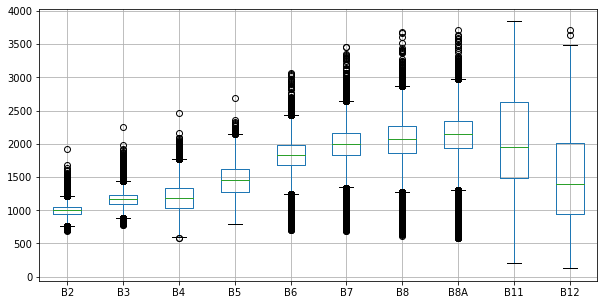

In [22]:
gdf.boxplot(column=['B2', 'B3', 'B4', 'B5', 'B6','B7','B8','B8A','B11','B12'])
plt.show()

### 4. Assigning Band values to X and y variable and train-test split (for training data)

In [26]:
# Assigning Band values to X variable

X = training_data.iloc[:, 2:12]
X

,B2 (MEAN),B3 (MEAN),B4 (MEAN),B5 (MEAN),B6 (MEAN),B7 (MEAN),B8 (MEAN),B8A (MEAN),B11 (MEAN),B12 (MEAN)
0,574.666667,541.888889,503.222222,502.111111,575.111111,584.222222,579.000000,577.777778,354.000000,260.111111
1,550.222222,527.444444,489.444444,510.111111,630.111111,622.666667,631.666667,620.777778,414.555556,296.000000
2,540.222222,523.444444,462.555556,464.777778,562.666667,574.000000,558.555556,564.222222,350.222222,262.333333
3,529.666667,517.222222,480.666667,516.444444,633.000000,662.555556,647.888889,660.000000,433.000000,305.222222
4,534.111111,550.333333,639.333333,732.000000,629.444444,688.000000,642.666667,592.444444,357.222222,264.444444
...,...,...,...,...,...,...,...,...,...,...
195,460.888889,452.333333,496.222222,773.444444,1189.000000,1312.222222,1297.000000,1324.333333,729.888889,470.777778
196,477.000000,472.777778,539.888889,821.444444,1152.777778,1258.555556,1253.888889,1256.777778,785.111111,551.111111
197,451.777778,451.444444,461.111111,737.555556,1283.111111,1427.555556,1440.333333,1437.666667,849.111111,553.000000
198,406.888889,427.666667,435.333333,748.666667,1260.444444,1370.444444,1347.666667,1385.666667,816.333333,529.222222


In [28]:
# Assigning Target Variables (Land Types) to y variable

y = training_data.select_dtypes(include=[object])
y

,land type
0,water
1,water
2,water
3,water
4,water
...,...
195,submergence
196,submergence
197,submergence
198,submergence


In [29]:
# Convert these categorical values to numerical values

le = preprocessing.LabelEncoder()
ct2num = le.fit(['water','tree set', 'crop', 'fallow', 'barren', 'submerge'])

y = y.apply(le.fit_transform)
y

,land type
0,5
1,5
2,5
3,5
4,5
...,...
195,3
196,3
197,3
198,3


In [30]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

print("Train_Test Split of X", X_train.shape, X_test.shape)
print("Train_Test Split of y", y_train.shape, y_test.shape)

Train_Test Split of X (140, 10) (60, 10)
Train_Test Split of y (140, 1) (60, 1)


### 4. Assigning Band values to X and y variable and train-test split (for bands)

In [31]:
# Assigning Band values to X variable

X = gdf.iloc[:, :10]
X

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12
0,1128.0,1258.0,1230.0,1408.0,1667.0,1808.0,1792.0,1866.0,1810.0,1444.0
1,1101.0,1204.0,1133.0,1298.0,1502.0,1556.0,1555.0,1592.0,1438.0,1056.0
2,1149.0,1313.0,1370.0,1567.0,1897.0,2014.0,2191.0,2117.0,2191.0,1867.0
3,1115.0,1230.0,1213.0,1411.0,1636.0,1797.0,1768.0,1875.0,1850.0,1451.0
4,1097.0,1190.0,1139.0,1292.0,1512.0,1573.0,1602.0,1550.0,1472.0,1137.0
...,...,...,...,...,...,...,...,...,...,...
388367,1191.0,1340.0,1188.0,1157.0,887.0,878.0,774.0,728.0,328.0,226.0
388368,1197.0,1357.0,1217.0,1133.0,884.0,877.0,813.0,741.0,303.0,188.0
388369,1201.0,1353.0,1175.0,1114.0,876.0,872.0,760.0,722.0,315.0,203.0
388370,1188.0,1308.0,1195.0,1092.0,841.0,837.0,773.0,695.0,297.0,187.0


### 5. Random Forest classification

A random forest is a machine learning technique that’s used to solve regression and classification problems. It utilizes ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problems. A random forest eradicates the limitations of a decision tree algorithm. It reduces the overfitting of datasets and increases precision. It generates predictions without requiring many configurations in packages.


In [34]:
# Train the Model

rf = RandomForestClassifier(n_estimators=10)
rf = rf.fit(X_train, y_train.values.ravel())

In [35]:
# Model prediction

Y_pred = rf.predict(X_test)

# Accuracy check

acc_rf = accuracy_score(y_test, Y_pred, normalize=False)
Class_Acc_RF = acc_rf/len(y_test)
print("Classification accuracy of RF is", Class_Acc_RF)

Classification accuracy of RF is 0.8


In [36]:
# Image classification and prediction result check and information

Y_pred_X = rf.predict(X)
Y_pred_X
type(Y_pred_X), Y_pred_X.dtype, Y_pred_X.ndim, Y_pred_X.shape, Y_pred_X.size

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- B11
- B12
- B2
- B3
- B4
- ...
Feature names seen at fit time, yet now missing:
- B11 (MEAN)
- B12 (MEAN)
- B2 (MEAN)
- B3 (MEAN)
- B4 (MEAN)
- ...

  warnings.warn(message, FutureWarning)


(numpy.ndarray, dtype('int64'), 1, (388372,), 388372)

In [37]:
# Scale back the data to the original representation

X_Class = le.inverse_transform(Y_pred_X)
X_Class

array(['water', 'water', 'barren', ..., 'water', 'water', 'water'],
      dtype=object)

In [38]:
df_X = pd.DataFrame(X_Class)
df_X

,0
0,water
1,water
2,barren
3,water
4,water
...,...
388367,water
388368,water
388369,water
388370,water


In [39]:
# Rename with Land Type

df_X_New = df_X.rename({0: 'Land Type'}, axis='columns')
df_X_New

,Land Type
0,water
1,water
2,barren
3,water
4,water
...,...
388367,water
388368,water
388369,water
388370,water


In [40]:
gdf_X = gpd.GeoDataFrame(df_X_New, geometry=gpd.points_from_xy(gdf.Longitude, gdf.Latitude))
gdf_X

,Land Type,geometry
0,water,POINT (88.84967 22.28720)
1,water,POINT (88.84994 22.28720)
2,barren,POINT (88.84940 22.28693)
3,water,POINT (88.84967 22.28693)
4,water,POINT (88.84994 22.28693)
...,...,...
388367,water,POINT (88.73109 22.05759)
388368,water,POINT (88.73136 22.05759)
388369,water,POINT (88.73163 22.05759)
388370,water,POINT (88.73190 22.05759)


<AxesSubplot:title={'center':'Random Forest classification'}>

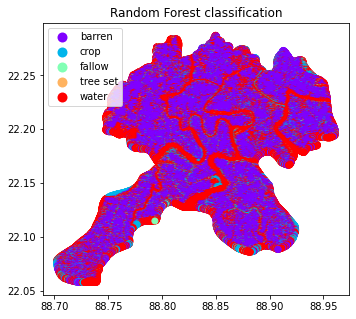

In [41]:
# Plot the classified result

fig, ax = plt.subplots(1, 1)
ax.set_title('Random Forest classification')
gdf_X.plot(column= 'Land Type', cmap= 'rainbow', ax=ax, legend = True)

In [43]:
from sklearn.metrics import classification_report,confusion_matrix #Helps us in visualizing the result performed by our model.

/tmp/ipykernel_1706/217343948.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train) #fitting on training data


classification Report :
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.89      1.00      0.94         8
           2       0.75      0.86      0.80         7
           3       0.50      0.44      0.47         9
           4       0.80      0.62      0.70        13
           5       0.82      1.00      0.90         9

    accuracy                           0.80        60
   macro avg       0.78      0.81      0.79        60
weighted avg       0.79      0.80      0.79        60

Acuuracy is:  0.8


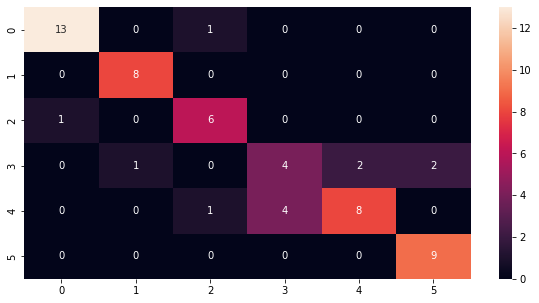

In [44]:
expected = y_test
predicted = rf.predict(X_test)

rf.fit(X_train, y_train) #fitting on training data
print('classification Report :\n', classification_report(y_test, rf.predict(X_test))) #classificatio report on validation set
cm = confusion_matrix(y_test, rf.predict(X_test)) #confusion matrix on validation set
sns.heatmap(cm, annot = True, fmt = 'd') #visualizing confusion matrix

print('Acuuracy is: ', accuracy_score(y_test, rf.predict(X_test))) #calculating accuracy score on validation set.

#### The overall accuracy for Random Forest Classification is 0.8

### 6. Artificial Neural Network classification

Artificial Neural Networks are a special type of machine learning algorithms that are modeled after the human brain. That is, just like how the neurons in our nervous system are able to learn from the past data, similarly, the ANN is able to learn from the data and provide responses in the form of predictions or classifications. ANNs are nonlinear statistical models which display a complex relationship between the inputs and outputs to discover a new pattern.


In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [56]:
# Train the Model

scaler = StandardScaler()
scaler.fit(X_train)

X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [57]:
from sklearn.neural_network import MLPClassifier
mlp= MLPClassifier(hidden_layer_sizes=(10), max_iter=300)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=10, max_iter=300)

<AxesSubplot:title={'center':'Artificial Neural Network classification'}>

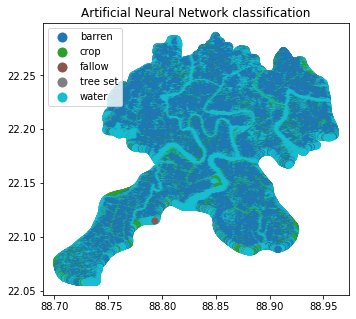

In [58]:
# Plot the classified result

fig, ax = plt.subplots(1, 1)
ax.set_title('Artificial Neural Network classification')
gdf_X.plot(column= 'Land Type', ax=ax, legend = True)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


classification Report :
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.73      1.00      0.84         8
           2       0.71      0.71      0.71         7
           3       0.45      0.56      0.50         9
           4       0.80      0.31      0.44        13
           5       0.82      1.00      0.90         9

    accuracy                           0.75        60
   macro avg       0.74      0.76      0.73        60
weighted avg       0.76      0.75      0.73        60

Acuuracy is:  0.75


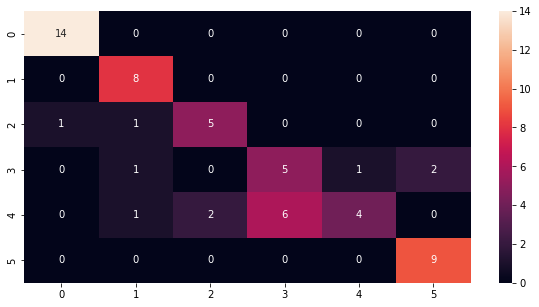

In [50]:
expected = y_test
predicted = mlp.predict(X_test)

mlp.fit(X_train, y_train) #fitting on training data
print('classification Report :\n', classification_report(y_test, mlp.predict(X_test))) #classificatio report on validation set
cm = confusion_matrix(y_test, mlp.predict(X_test)) #confusion matrix on validation set
sns.heatmap(cm, annot = True, fmt = 'd') #visualizing confusion matrix

print('Acuuracy is: ', accuracy_score(y_test, mlp.predict(X_test))) #calculating accuracy score on validation set.

#### The overall accuracy for Random Forest Classification is 0.75

#### 7. Support Vector Machine
SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems.  It creates a line or a hyperplane which separates the data into classes.


In [53]:
from sklearn.svm import SVC

svm = SVC(C=3.0, kernel='rbf', degree=6, cache_size=1024)

# Fit Data
svm.fit(X_train, y_train)

# Predict labels for test data
svm_pred = svm.predict(X_test)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
print(y_test, svm_pred)

     land type
42           4
116          0
155          2
174          3
172          2
136          0
132          0
180          3
10           5
171          2
36           5
131          0
106          1
26           5
130          0
29           5
92           1
43           4
113          0
90           1
120          0
47           4
160          2
51           4
139          0
119          0
175          3
1            5
94           1
16           5
39           5
103          1
28           5
53           4
77           1
52           4
64           4
181          3
101          1
63           4
145          2
196          3
129          0
126          0
134          0
169          2
3            5
184          3
58           4
195          3
162          2
122          0
185          3
65           4
85           1
49           4
111          0
41           4
56           4
177          3 [4 2 2 4 2 0 0 3 5 2 5 0 1 5 0 5 1 4 0 1 0 2 2 4 0 0 4 5 1 5 5 1 5 4 1 4 3
 4 1 4 0 5

<AxesSubplot:title={'center':'Support Vector Machine'}>

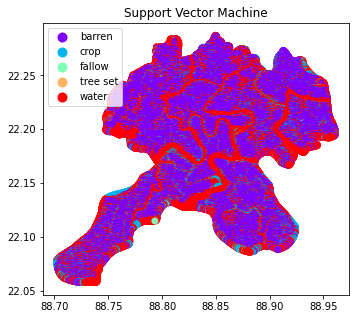

In [55]:
# Plot the classified result

fig, ax = plt.subplots(1, 1)
ax.set_title('Support Vector Machine')
gdf_X.plot(column= 'Land Type', cmap= 'rainbow', ax=ax, legend = True)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


classification Report :
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.89      1.00      0.94         8
           2       0.75      0.86      0.80         7
           3       0.80      0.44      0.57         9
           4       0.79      0.85      0.81        13
           5       0.90      1.00      0.95         9

    accuracy                           0.85        60
   macro avg       0.84      0.85      0.83        60
weighted avg       0.85      0.85      0.84        60

Acuuracy is:  0.85


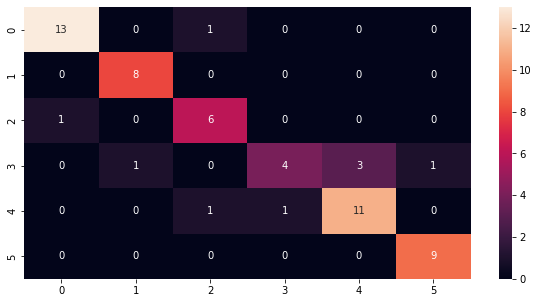

In [59]:
expected = y_test
predicted = svm.predict(X_test)

svm.fit(X_train, y_train) #fitting on training data
print('classification Report :\n', classification_report(y_test, svm.predict(X_test))) #classificatio report on validation set
cm = confusion_matrix(y_test, svm.predict(X_test)) #confusion matrix on validation set
sns.heatmap(cm, annot = True, fmt = 'd') #visualizing confusion matrix

print('Acuuracy is: ', accuracy_score(y_test, svm.predict(X_test))) #calculating accuracy score on validation set.

#### The overall accuracy for support Vector Machine is 0.85

### 8. CART classification in GEE
Google Earth Engine is a cloud-based platform for planetary-scale geospatial analysis using Google's massive computational capabilities. GEE combines a multi-petabyte catalogue of satellite imagery and geospatial datasets with planetary-scale analysis capabilities and makes it available for scientists, researchers, and developers to detect changes, map trends, and quantify differences on the Earth's surface.

A Classification And Regression Tree (CART), is a predictive model, which explains how an outcome variable's values can be predicted based on other values. A CART output is a decision tree where each fork is a split in a predictor variable and each end node contains a prediction for the outcome variable.Classification And Regression Tree

In [61]:
# Importing GEE libraries
import ee
import geemap
#import sys

In [62]:
try:
  ee.Initialize()
  print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
  print('Google Earth Engine has failed to initialize!')
except:
  print("Unexpected error:", sys.exc_info()[0])
  raise

Google Earth Engine has initialized successfully!


In [63]:
Map = geemap.Map()
fc_shape=ee.FeatureCollection('projects/ee-debolina9512/assets/sundarban')
fc_point=ee.FeatureCollection('projects/ee-debolina9512/assets/PointData')

Map.centerObject(fc_shape,11)
Map.addLayer(fc_shape,{},'Sundarban',0)

Map.addLayer(fc_point,{},'Point',0)

image1= ee.ImageCollection("COPERNICUS/S2_SR") \
  .filterDate('2020-12-01','2021-03-31') \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)) \
  .filterBounds(fc_shape) \
  .median()

#print (image1.bandNames())
#print (fc_point.size())
#print (fc_point.first()) 
#print (image.bandTypes())  


#vizparams= {bands:['B12','B11','B8A','B8','B7','B6','B5','B4','B3','B2'], min:0, max:2500,gamma:1.1}

vizparams= {'bands':['B4','B3','B2'], 'min':0, 'max':2500,'gamma':1.1}

#print(vizparams.bands)


Map.addLayer(image1.clip(fc_shape),vizparams,'Sentinel-2')

water= fc_point.filter(ee.Filter.eq('land_type','water'))
treeset=fc_point.filter(ee.Filter.eq('land_type','tree set'))
crop=fc_point.filter(ee.Filter.eq('land_type','crop'))
fallow=fc_point.filter(ee.Filter.eq('land_type','fallow'))
barren=fc_point.filter(ee.Filter.eq('land_type','barren'))
submerge=fc_point.filter(ee.Filter.eq('land_type','submerge'))


training= water.merge(treeset).merge(crop).merge(fallow).merge(barren).merge(submerge)
#print(training)

label= "id"; #id=1,2,3,4,5,6 based on land_type
bands=['B2','B3','B4','B8']
#bands= ['B12','B11','B8A','B8','B7','B6','B5','B4','B3','B2']
input= image1.select(bands)

trainingImage=input.sampleRegions(**{
  'collection':training,
  'properties':[label],
  'scale':30
})

trainingData=trainingImage.randomColumn()
trainingSet=trainingData.filter(ee.Filter.lessThan('random',0.7))
testSet=trainingData.filter(ee.Filter.greaterThanOrEquals('random',0.7))
#print(trainingSet)
#print(testSet)

classifier= ee.Classifier.smileCart().train(trainingSet, label, bands)
classified=input.classify(classifier)
#print(classified)

landcoverPallete=[
  '0F0779',
  '074605',
  '6DD10D',
  'E62004', 
  '705F5C',
  '5C706D'
]

Map.addLayer(classified.clip(fc_shape), {'palette':landcoverPallete, 'min':1, 'max':6}, 'Classified Layer')

confusionMatrix= ee.ConfusionMatrix(testSet.classify(classifier)
  .errorMatrix(**{
    'actual':'id',
    'predicted':'classification'
  }))
#print('Confusion Matrix',confusionMatrix)
#print('Overall Accuracy:',confusionMatrix.accuracy())
print('Confusion Matrix:',confusionMatrix.getInfo())
print('Overall Accuracy:',confusionMatrix.accuracy().getInfo())
print('Producer Accuracy:',confusionMatrix.producersAccuracy().getInfo())
print('Kappa Accuracy:',confusionMatrix.kappa().getInfo())

Map

Confusion Matrix: [[0, 0, 0, 0, 0, 0, 0], [0, 6, 2, 0, 0, 1, 1], [0, 0, 9, 0, 0, 0, 0], [0, 0, 3, 10, 1, 0, 0], [0, 1, 0, 0, 13, 0, 1], [0, 1, 0, 1, 7, 7, 0], [0, 0, 0, 0, 2, 0, 1]]
Overall Accuracy: 0.5818181818181818
Producer Accuracy: [[0], [0.46153846153846156], [0.7142857142857143], [0.8823529411764706], [0.6666666666666666], [0.6], [0.5]]
Kappa Accuracy: 0.5882129277566539


Map(center=[22.183251043035266, 88.84193831128376], controls=(WidgetControl(options=['position', 'transparent_…

### Results
<i>The overall accuracy for these classifications are-

    Random Forest classification is 0.8
    
    Artificial Neural Network is 0.75
 
    Support Vector Machine is 0.85

    Classification And Regression Tree is 0.588

It is observed that there are clear margin of separation between classes as well as our ground truth point data. Therefore the highest accuracy (0.85) is found in Support Vector Machine(SVM) classification algorithm.
    
On the other hand the lowest accuracy found in  Classification And Regression Tree (CART) (0.588) algorithm. As we introduced a new class in the training point data the accuracy reduced remarkably. But when the new class is removed the accuracy becomes almost 0.8.

### Conclusions

The proposed  work is expected to provide a general information about the best fitted model for monitoring land cover, specially fallow land area of Gosaba block of Indian Sundarban region. From the project it is observed that the SVM algorithm performs best result. However there are scopes to improve the accuracy of land classification by increasing the number of precise ground truth data point, incorporating Hyperparameter Optimization etc. The work can be expanded throughout all the coastal blocks of Sundarban. 

 

### Contribution from each member of the group_1
1. Hasan Md. Hamidur Rahman : Data export and classification using CART algorithm in GEE
1. Afroza Begum : Data analysis with ESDA, Boxplot, DASK
1. Debolina Sarkar : Data collection, Data preparation, classification using RF, ANN, SVM
